<h1>PRIMERA APROXIMACIÓN AL PROBLEMA<h1>

<h2>INTRODUCCIÓN<h2>

Para ilustrar el ejemplo se utiliza el dataset [SURVEY LUNG CANCER](https://www.kaggle.com/datasets/mysarahmadbhat/lung-cancer), cuyas características son:
 
Total no. of attributes:16
No .of instances:284
Attribute information:

    Gender: M(male), F(female)
    Age: Age of the patient
    Smoking: YES=2 , NO=1.
    Yellow fingers: YES=2 , NO=1.
    Anxiety: YES=2 , NO=1.
    Peer_pressure: YES=2 , NO=1.
    Chronic Disease: YES=2 , NO=1.
    Fatigue: YES=2 , NO=1.
    Allergy: YES=2 , NO=1.
    Wheezing: YES=2 , NO=1.
    Alcohol: YES=2 , NO=1.
    Coughing: YES=2 , NO=1.
    Shortness of Breath: YES=2 , NO=1.
    Swallowing Difficulty: YES=2 , NO=1.
    Chest pain: YES=2 , NO=1.
    Lung Cancer: YES , NO.

El problema que utilizaremos como ejemplo de aplicación es un análisis sencillo. Queremos contar cuántos casos de cáncer existen en función de si los individuos son fumadores o no. 


<h2> HERRAMIENTAS UTILIZADAS <h2>

La salida es un documento html exportado desde una libreta de Jupyter Notebook. El código está escrito en lenguaje Python3 y la matemática con comandos de $\LaTeX$. 

<h2>CIFRADO HOMOMÓRFICO<h2>

El uso de un sistema de cifrado homomórfico está motivado por la obtención de un algoritmo de descifrazo que defina, para una clave privada, un homomorfismo de grupos entre el espacio del mensaje cifrado ($\mathcal{C}$) y el del mensaje sin cifrar ($\mathcal{M}$): 

$$ f: \mathcal{C} \rightarrow \mathcal{M} $$

Así, podremos enviar la información cifrada al servicio Cloud, para tratarla encriptada y, posteriormente, traer al local las conclusiones para ser descifradas. Para una primera aproximación tomamos el sistema RSA simplificado. 

La clave pública es un par $(N,e)$ donde $N = p \cdot q$ es producto de dos primos $p$ y $q$ suficientemente grandes y distintos. Por otro lado, $e$ es el llamado exponente de cifrado que es un entero positivo tal que mcd $(e,\phi(N)) = 1$, donde $\phi(N) = (p-1)(q-1)$ es la función $\phi$ de Euler. 

La clave privada es el par $(N,d)$ donde $d$ es el exponente de descifrado (i.e. el inverso de $e$ módulo $\phi(n)$). De este modo se verifica que 

$$ e \cdot d \equiv 1\, (mod\, (p-1)(q-1))$$

así 

$$ \mathcal{M} = \mathcal{C} = (\mathbb{Z}_N)^* $$

que es el grupo multiplicativo de las unidades módulo n, cuyos elementos son 

$$ m \in \mathbb{Z}: 1 \leq m < N \wedge mcd\, (m,n) = 1 $$

quedando el homomorfismo de grupos 

$$ E: (\mathbb{Z}_N)^* \longrightarrow (\mathbb{Z}_N)^* $$
$$ m \mapsto m^e\, mod \, N $$

que es un isomorfismo, que permite descifrar un mensaje cifrado $c$ através de su inverso  

$$D(c) = c^d \, mod \, N$$

La utilidad de esto radica en que $((\mathbb{Z}_N)^*,\; \cdot)$ es un grupo multiplicativo, por tanto 

$$ \begin{equation} \tag{h}
E(m_1 \cdot m_2) = E(m_1) \cdot E(m_2)
\end{equation} 
$$  

<h2>APLICACIÓN AL DATASET DEL CÁNCER DE PULMÓN<h2>

En primer lugar vamos a definir dos funciones, una para encriptar un tipo int y otra para desencriptarlo. Los parámetros de entrada para la función que encripta serán: 
<ul>
<li>publicKey -> Lista que contiene: N, e </li>
<li>mensaje -> int </li>
</ul>
mientras que para la función que desencipta tendremos:
<ul>
<li>privateKey -> Lista que contiene: N, d </li>
<li>criptotexto -> int </li>
</ul>

Las funciones se muestran a continuación: 

In [1]:
def E_RSA(publicKey, mensaje): 
    n = publicKey[0]
    e = publicKey[1]
    return pow(mensaje, e, n)

def D_RSA(privateKey, criptotexto): 
    n = privateKey[0]
    d = privateKey[1]
    return pow(criptotexto, d, n)

Suponemos ahora que tenemos cifrada la columna *SMOKING* del dataset. Una primera opción que se ha trabajado es exportar el csv a un data frame, pero el tipo int64 con el que trabaja pandas colisiona con el uso del método *pow*. De momento, optaré por una solución más rudimentaria para encriptar la columna y poder ilustrar este ejemplo.

In [2]:
fumar = []
with open('survey_lung_cancer.csv', 'r') as archivo: 
    lineas = archivo.read().splitlines()
    #borro encabezado
    lineas.pop(0)
    for l in lineas: 
        linea = l.split(',')
        fumar.append(int(linea[2]))

De esta forma, hemos creado la columna *fumar* que contiene los enteros 1 si la persona no era fumadora y 2 si la persona era fumadora. Ambas entradas de tipo int. De modo que ya podemos encriptar secuencialmente la columna. 

Para ello definimos los valores que gobiernan el ejemplo: 

In [3]:
e = 2**16 + 1                       #exponente de cifrado 
p = 409                             #primo 
q = 317                             #primo
n = p * q                           #producto de dos primos distintos 

phi_n = (p-1)*(q-1)                 #cálculo de la función phi de Euler para n

pubKey = [n, e]                     #Clave publica 
priKey = [n, pow(e,-1,phi_n)]       #clave privada

Ciframos la columna *fumar*

In [4]:
fumar_encrip = []
for elemento in fumar: 
    fumar_encrip.append(E_RSA(pubKey, elemento))

Ahora vamos hacer el cálculo pedido: encontrar cuántos pacientes de cáncer de pulmón eran fumadores y cuántos no. En primer lugar, las entradas del dataset son el 1 y un número primo. Por el teorema fundamental de la aritmética sabemos que todo entero positivo mayor que 1 es un número primo o bien un único producto de números primos. De modo que el número de pacientes fumadores se puede obtener fácilmente, ya que conocemos los factores involucrados en la descomposición del producto de todos los elementos de la columna *fumar_encrip*. Sólo nos falta por conocer sus exponentes para extraer la información pedida. 

Calculamos el productorio módulo n de *fumar_encrip*

In [5]:
from math import prod
producto = (prod(fumar_encrip)) % n
producto

84172

Esta operación con los datos encriptados se habría hecho en la estructura del proveedor cloud y exportaríamos al local, únicamente, la variable *producto*. 

Una vez en local, el usuario conocería la clave privada por lo que podría desencriptarlo y *factorizarlo* para extraer la información buscada gracias a (h). 

En este caso, por ser una de las entradas un 1, el único primo es 2, por lo que buscamos su exponente y mediante la diferencia respecto al total obtenemos el número de pacientes no fumadores. La función que factorizará *producto* simplemente eleva iterativamente 2, una unidad más en cada paso, hasta obtener el valor de la variable *producto*.

In [6]:
def factP(mensaje_descifrado, n): 
    result = 0
    num = 0
    while(num != mensaje_descifrado): 
        result += 1
        num = pow(2,result,n)
        
    return result 

In [7]:
fumadores = factP(D_RSA(priKey, producto), n)
total = len(fumar)
no_fumadores = abs(total - fumadores)
print(f'El total de pacientes fumadores es: {fumadores}. \nEl total de pacientes no fumadores es: {no_fumadores}. \nDe un total de {total} pacientes.')

El total de pacientes fumadores es: 174. 
El total de pacientes no fumadores es: 135. 
De un total de 309 pacientes.


<h2>LIMITACIONES<h3>

El proceso que se acaba de describir es inútil desde el punto de vista de la seguridad. Al ser un proceso determinista, es decir, los pacientes fumadores y no fumadores se cifran siempre de la misma manera, no podemos presuponer que alguien que quiera hacer un uso fraudulento de la información desconoce los elementos involucrados en el algoritmo (*principio de Kerckhoffs*). 

Esto se puede traducir en que, en el peor caso, con un par de evaluaciones obtenemos si un paciente es o no fumador: 

In [8]:
valor = E_RSA(pubKey, 1)
print(f'Buscamos la representación de 1')
if (not E_RSA(pubKey, 1) == valor):
    E_RSA(pubKey, 2) == valor
    print("Representa: Es fumador")
else: 
    print("Representa: No es fumador")

Buscamos la representación de 1
Representa: No es fumador


La probabiliad de distinguir al fumador del no fumador es 1. El objetivo sería no ser capaces de acertar con probabilidad significativamente mayor que $\dfrac{1}{2}$. 

La definición asintótica de la probabilidad insignificante supone que, si alguien intenta distinguir los mensajes lo hace con probabiliad $\dfrac{1}{2}+\dfrac{1}{f(k)}$, donde $k$ es la longitud del módulo RSA y $f(k)$ una función polinómica, entonces el algoritmo no es seguro. 

<h1>MEJORANDO EL SISTEMA<h1>

Un algoritmo de cifrado que es homomórfico y CPA seguro es el de Paillier. Se dice que un procedimiento es CPA seguro si en tiempo polinómico un atacante no puede distinguir entre dos criptotextos partiendo de dos textos sin cifrar elegidos por él.

Las fases que gobiernan el algoritmo de Paillier son tres, a saber: 
* **Generar las claves**. Se generan dos primos aleatorios $p$ y $q$ y se obtiene la clave pública $n=pq$ y la clave privada $(n, \phi(n))$. Por simplicidad, supondremos que $p$ y $q$ tienen la misma longitud. 
* **Cifrar**. El conjunto de textos sin cifrar será $\mathbb{Z}_n$ y el de criptotextos $(\mathbb{Z}_{n^2})^*$. Para cifrar un mensaje $m \in \mathbb{Z}_n$, se elige $r \in (\mathbb{Z}_{n^2})^*$ al *azar* y se calcula el criptotexto como 

$$c = E(n, m) := ((1+n)^m \cdot r^n)\, mod \, n^2 \in (\mathbb{Z}_{n^2})^* \tag{Encriptación con Paillier} $$

* **Descifrar**. Para descrifrar $c$ con la clave privada $(n, \phi(n))$ se hace $$m = D((n, \phi(n)), c) := \dfrac{(c^{\phi(n)}\, mod\, n^2)-1}{n} \cdot \phi(n)^{-1} \, mod \, n \tag{Desencriptación con Paillier} $$ donde $((c^{\phi(n)}\, mod\, n^2)-1)/n$ se calcula en $\mathbb{Z}$.

Ahora bien, $\mathbb{Z}_n$ es aditivo, y $(\mathbb{Z}_{n^2})^*$ multiplicativo, por lo que la función de descifrado de Paillier lleva un producto de criptotextos en $(\mathbb{Z}_{n^2})^*$ a la suma de los textos sin cifrar en $\mathbb{Z}_{n}$. Sean $m_1$ y $m_2 \in \mathbb{Z}_n$, entonces $c_1 = E(n, m_1)$ y $c_2 = E(n, m_2)$ de donde  

$$D((n, \phi(n), c), (c_1 \cdot c_2)\, mod \, n^2) = (m_1 + m_2) \, mod \, n \tag{Propiedad homomórfica} $$ 

La aplicación $D: (\mathbb{Z}_{n^2})^* \rightarrow \mathbb{Z}_{n}$ inducida por el algoritmo de descifrado con una clave fija es un homomorfismo de grupos (no se puede afirmar lo mismo del de cifrado por ser probabilista). No obstante, es cierto que para cifrar la suma de varios mensajes se puede tomar como criptotexto el productorio de los criptotextos asociados a cada mensaje. 

<h2>APLICACIÓN AL DATASET DEL CÁNCER DE PULMÓN<h2>

Importamos la función $ \texttt{getprimeover(N)} $ la cual retorna un primo de N-bits usando GMP o, si no está accesible, PyCrypto; que son librerías criptográficas de Python. Además, importamos $ \texttt{random} $ para hallar $r \in (\mathbb{Z}_{n^2})^* $

In [9]:
from phe.util import getprimeover
from random import *

Generamos las claves pública y privada suponiendo que la longitud de N es de 1024. Generalmente se usan longitudes de 3072 (como hace la librería $ \texttt{Paillier} $ de $ \texttt{phe} $)

In [10]:
N_LEN = 1024
p = q = n = None
n_len = 0
while n_len != N_LEN:
    p = getprimeover(N_LEN // 2)
    q = p
    while q == p:
        q = getprimeover(N_LEN // 2)
    n = p * q
    n_len = n.bit_length()


phi_n_P = (p-1) * (q-1)
public_key_P = n 
private_key_P = [n, phi_n_P]

Implementamos un procedimiento para encriptar, según lo visto en (Encriptación con Paillier), y un procedimiento para desencriptar, según lo visto en (Desencriptación con Paillier)

In [11]:
def E_PAI(publicKey, mensaje): 
    r = randint(1, n) 
    nc = n**2
    return pow((1+n), mensaje, nc) * pow(r, n, nc)

def D_PAI(privateKey, criptotexto): 
    n = privateKey[0]
    phi = privateKey[1]
    nc = n**2

    numerador = ((pow(criptotexto, phi, nc) - 1) // n) % n
    denominador = pow(phi, -1, n)
    return (numerador * denominador) % n 


Encriptamos la columna SMOKING del dataset

In [15]:
fumar_encrip_P = []
for elemento in fumar: 
    fumar_encrip_P.append(E_PAI(public_key_P, elemento))

Calculamos 
$$ \texttt{producto\_p} = \prod_{i=0}^{i = l} c_i \, mod \, n^2 $$
donde l es la longitud de la lista *fumar_encrip_P*

In [16]:
producto_P = 1
for elemento in fumar_encrip_P:
    producto_P = (producto_P * elemento) % n**2

observamos que el elemento resultante está en $ (\mathbb{Z}_{n^2})^* $

In [17]:
print(f'producto: {len(str(producto_P))} \nn**2: {len(str(n**2))}')

producto: 616 
n**2: 617


Este valor lo traeríamos al local dentro nuestra empresa. Ahora, sabemos que para descrifrarlo es un homomorfismo según la propiedad descrita en (Propiedad homomórfica), la función de descifrado obtendrá
$$  \sum_{i=0}^l m_i \, mod \, n  $$  

dicho numero debe representar la suma de pacientes fumadores y no fumadores de la columna SMOKING del dataset

In [18]:
cyf = D_PAI(private_key_P, producto_P)
cyf

483

Dado que las entradas elegidas para representar el *si* y el *no* son 2 y 1, este camino no sirve pues no sería posible. Al ser una suma, descomponerla y obtener la información deseada no es viable. El valor obtenido 483, es coherente con la solución obtenida con RSA, la cual decía: 

$$ \texttt{El total de pacientes fumadores es: 174.} $$ 
$$ \texttt{El total de pacientes no fumadores es: 135.} $$

es decir, 

$$ 172 \cdot 2 + 135 \cdot  1 = 483 $$

como hemos obtenido. El sistema funciona como se esperaba. 

No obstante, para poder usar este método de forma eficaz, necesitamos que las entradas sean, por ejemplo, 0 y 1, de forma que la suma obtenida ya representaría el total de una de las dos opciones, siendo la otra la diferencia respecto del total de casos estudiados. 

Un posible ejemplo de aplicación sería calcular la media de edad por el genero de los pacientes. Para ello, en primer lugar vamos a crear una lista en la que convertimos M en 0 y F en 1, para poder discriminar el genero del paciente. En otra lista tendremos la edad de cada paciente. 

In [28]:
genero = []
edad = []
with open('survey_lung_cancer.csv', 'r') as archivo: 
    lineas = archivo.read().splitlines()
    #borro encabezado
    lineas.pop(0)
    for l in lineas: 
        linea = l.split(',')
        genero.append(linea[0])
        edad.append(int(linea[1]))

for i in range(len(genero)):
    if genero[i] == 'M': 
        genero[i] = 0
    else: 
        genero[i] = 1

data = list(zip(genero, edad))

Mostramos una parte de la lista data

In [29]:
print(data[10:20])

[(1, 61), (0, 72), (1, 60), (0, 58), (0, 69), (1, 48), (0, 75), (0, 57), (1, 68), (1, 61)]


Ciframos la lista data 

In [30]:
generoENCP = []
for elemento in genero: 
    generoENCP.append(E_PAI(public_key_P, elemento))

In [32]:
edadENCP = []
for elemento in edad: 
    edadENCP.append(E_PAI(public_key_P, elemento))

In [33]:
data_ENCP = list(zip(generoENCP, edadENCP))

In [38]:
def prodMod(lista, mod):
    producto_P = 1
    moD = mod**2
    for elemento in lista:
        producto_P = (producto_P * elemento) % moD
    return producto_P

In [39]:
result = (prodMod(generoENCP, n), prodMod(edadENCP, n))

In [45]:
resultDECRIP = (D_PAI(private_key_P, result[0]), (D_PAI(private_key_P, result[1])))

In [59]:
total = len(genero)
mujeres = resultDECRIP[0]
hombres = abs(mujeres - total)
media_edad = resultDECRIP[1] / total

In [49]:
import matplotlib.pyplot as plt

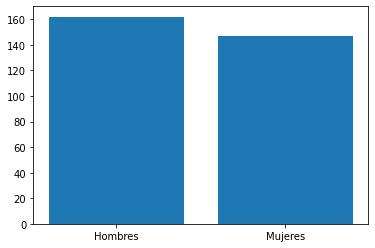

CONCLUSIÓN: 
La media de edad de los pacientes es de 62.7 años. 
Hay un total de 309 pacientes, de los cuales 162 son hombres, y 147 son mujeres.


In [63]:
plt.bar(['Hombres', 'Mujeres'], [hombres, mujeres])
plt.show()
print(f'CONCLUSIÓN: \nLa media de edad de los pacientes es de {round(media_edad, 1)} años. \nHay un total de {total} pacientes, de los cuales {hombres} son hombres, y {mujeres} son mujeres.')

<h2> SEGURIDAD <h2>

Si reproducimos el ataque que hicimos para RSA encontramos una diferencia sustancial: **dos textos claros no siempre tienen el mismo criptotexto**. En efecto: 

In [ ]:
dos = E_PAI(public_key_P, 2)
otro_dos = E_PAI(public_key_P, 2)

dos == otro_dos

<h2>LIMITACIONES<h2>

Podría parecer que hemos resuelto el problema. Pero nada más lejos de la realidad. Hemos impuesto que nuestro sistema de cifrado, además de homórfico, sea CPA seguro. Pero se conocen formas de atacar a estos sistemas permitiendo conocer, en nuestro caso, si un paciente en concreto es o no fumador. Este tipo de ataques se conocen como ataques CCA. Como en el caso CPA se elegirán dos mensajes, y uno de ellos (al azar) es cifrado, y el criptotexto es entregado al atacante que intenta descifrar a cuál corresponde. Además, el atacante puede adaptar el ataque según las respuesta que obtenga. Veamos que ocurre con nuestro ejemplo:

En primer lugar ciframos el 1

In [ ]:
uno = E_PAI(public_key_P, 1)
uno 

El atacante, puede utilizar la propiedad homomórfica. Sea c el primer elemento de $ \texttt{fumar\_encrip\_P} $ 

$$ \texttt{c1} := (\texttt{uno} \cdot \texttt{c}) \, mod \, n^2 $$

y además, sabe que 

$$ \texttt{D\_PAI(private\_key\_p, uno) = 1} $$

In [ ]:
c1 = (uno * fumar_encrip_P[0]) % (n**2) 
D_PAI(private_key_P, c1) - 1

ergo el primer paciente, no era fumador. 

"Un esquema criptográfico se dice no maleable si la probabilidad de que el adversario encuentre dichos textos [...] no es significativamente mayor que dicha probabilidad para el cifrado de una cadena de bits $ x $ elegida al azar." (González Vasco, 2003, p.26)

Por tanto decimos que el método de Paillier es maleable. Un atacante puede modificar el criptotexto del ataque y obtener otro criptotexto relacionado de forma que su texto claro esté relacionado con el texto claro que se quiere descifrar. 

<h3>BIBLIOGRAFÍA</h3>

González Vasco, M. I. (2003). Criptosistemas basados en Teoría de grupos.

Milanov, E. (2009). The RSA algorithm. RSA laboratories, 1-11.

Pardo, J. L. G. (2012). Cifrado homomórfico: ejemplos y aplicaciones. Gaceta de la Real Sociedad Matematica Española, 15(4), 697-712.